In [1]:
%pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 19.8 MB/s eta 0:00:00


In [2]:
import torch
from torch import nn
import torch.quantization
import pytorch_lightning as pl
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, Callback
from pytorch_lightning.loggers import TensorBoardLogger
import pandas as pd
import numpy as np

In [3]:
import requests

url = "https://www.dropbox.com/scl/fi/x2eh2yil56rgu5id1fwbm/cnn_data1.csv?rlkey=7bltxkitlwdnuirw08r2ysuv4&st=nppxtfhe&dl=1"
response = requests.get(url)

# Save the file locally
with open('cnn_data1.csv', 'wb') as file:
    file.write(response.content)

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

def plot_data_hist(df):
    # Define figure size and layout for subplots
    fig, axs = plt.subplots(3, 5, figsize=(15, 15), dpi=80)

    # List of columns to plot histograms for
    columns = ['Depth', 'Activation Function', 'Total Activations', 'Total_Activations_Batch_Size', 'Total Parameters', 'Batch Size',
               'Conv2d Count','BatchNorm2d Count', 'Dropout Count', 'AdaptiveAvgPool2d Count',
               'Linear Count', 'Max GPU Memory (MiB)', 'architecture',
               'Input Size (MB)', 'Forward/Backward Pass Size (MB)','Params Size (MB)', 'Estimated Total Size (MB)']

    # Loop over the axes and columns to create histograms
    for ax, col in zip(axs.ravel(), columns):
        if pd.api.types.is_numeric_dtype(df[col]):
            ax.hist(df[col], bins=200)
            ax.set_xlabel(col)
            ax.set_ylabel('count')
        else:
            print(f"Skipping non-numeric column: {col}")

    # Adjust layout for better readability
    plt.tight_layout()
    plt.show()


0       39517
1       36831
2        6293
3        6475
4        2779
        ...  
8995    40123
8996    38637
8997    26097
8998    39617
8999     4321
Name: Max GPU Memory (MiB), Length: 9000, dtype: int64
#datapoints:  9000
0       39517
1       42000
2        6293
3        6475
4        2779
        ...  
8995    42000
8996    42000
8997    26097
8998    42000
8999     4321
Name: Max GPU Memory (MiB), Length: 9000, dtype: int64
#datapoints:  9000
Depth | max :  119 | min:  5
Activation Function | max :  Tanh | min:  ELU
Total Activations | max :  5317481490 | min:  24514
Total_Activations_Batch_Size | max :  258908974214 | min:  208120
Total Parameters | max :  329307377 | min:  704
Batch Size | max :  62 | min:  2
Conv2d Count | max :  29 | min:  1
BatchNorm2d Count | max :  29 | min:  0
Dropout Count | max :  29 | min:  0
AdaptiveAvgPool2d Count | max :  1 | min:  1
Linear Count | max :  1 | min:  1
Max GPU Memory (MiB) | max :  42000 | min:  1703
architecture | max :  uniform |

<Figure size 10000x800 with 0 Axes>

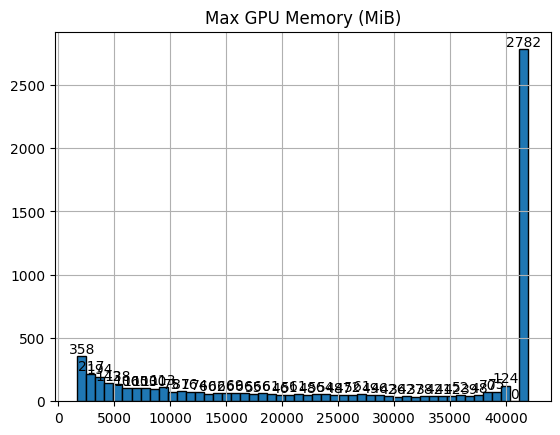

In [5]:
csv_file_path = "cnn_data1.csv"  # Replace with the actual path to the produced CSV file

# Load the CSV into a DataFrame and assign it to the desired column names
df = pd.read_csv(csv_file_path)


print(df['Max GPU Memory (MiB)'])
print("#datapoints: ", len(df))

df['Total_Activations_Batch_Size'] = df['Total Activations'] * df['Batch Size']

df.loc[df['Status'] == 'OOM_CRASH', 'Max GPU Memory (MiB)'] = 42000


print(df['Max GPU Memory (MiB)'])

print("#datapoints: ", len(df))


df = df.dropna(subset=['Activation Function'])

df = df[~df['architecture'].isin(['residual', 'dense'])]


df = df[['Depth', 'Activation Function', 'Total Activations', 'Total_Activations_Batch_Size', 'Total Parameters', 'Batch Size',
               'Conv2d Count','BatchNorm2d Count', 'Dropout Count', 'AdaptiveAvgPool2d Count',
               'Linear Count', 'Max GPU Memory (MiB)', 'architecture',
               'Input Size (MB)', 'Forward/Backward Pass Size (MB)','Params Size (MB)', 'Estimated Total Size (MB)']]


columns_to_analyze = ['Depth', 'Activation Function', 'Total Activations', 'Total_Activations_Batch_Size', 'Total Parameters', 'Batch Size',
                        'Conv2d Count','BatchNorm2d Count', 'Dropout Count', 'AdaptiveAvgPool2d Count',
                        'Linear Count', 'Max GPU Memory (MiB)', 'architecture',
                        'Input Size (MB)', 'Forward/Backward Pass Size (MB)','Params Size (MB)', 'Estimated Total Size (MB)']

for col in columns_to_analyze:
    if col == 'activation_function':
      continue
    print(f'{col} | max : ', df[col].max(), '| min: ', df[col].min())
print('len dataset: ', len(df))


# Plotting the histogram of 'Max GPU Memory (MiB)' with increased figure size and labeled bins
plt.figure(figsize=(100, 8))  # Increase the size of the figure
ax = df[['Max GPU Memory (MiB)']].hist(bins=50, edgecolor='black')

# Adding labels to the bins
for ax in plt.gcf().axes:
    for patch in ax.patches:
        # Get the coordinates and height of each bar (bin)
        height = patch.get_height()
        width = patch.get_width()
        # Calculate the position where the text will be displayed
        bin_center = patch.get_x() + width / 2
        # Display the height (number of items in each bin)
        ax.text(bin_center, height, int(height), ha='center', va='bottom')

plt.show()

Skipping non-numeric column: Activation Function
Skipping non-numeric column: architecture


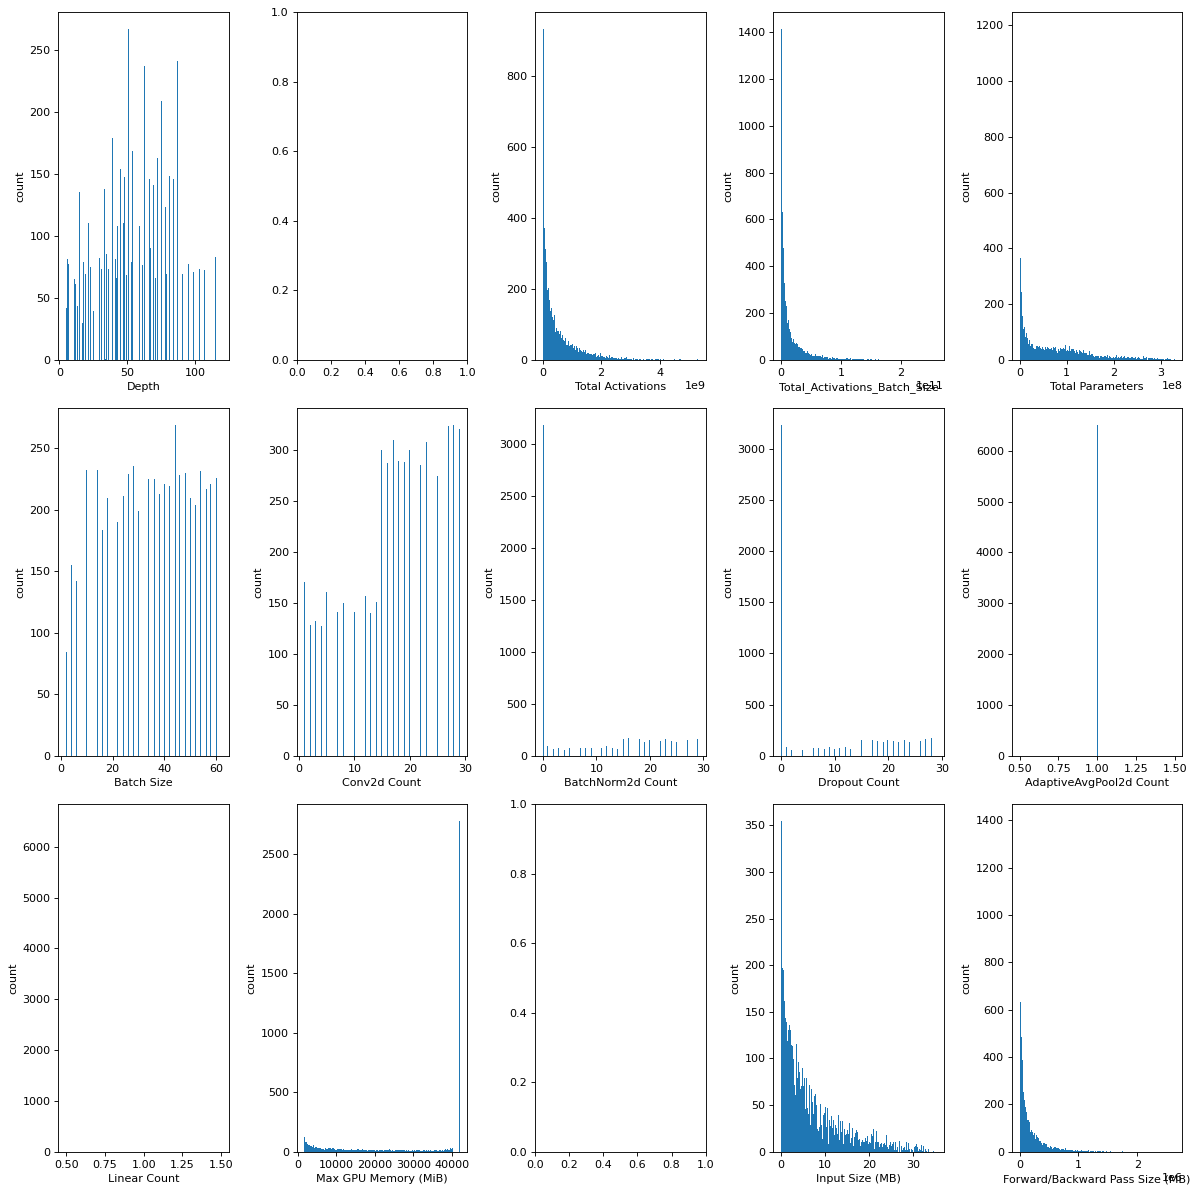

In [6]:
plot_data_hist(df)

# having activations functions as two separate columns

In [7]:
# List of activation functions
activations = ['ELU', 'GELU', 'LeakyReLU', 'Mish', 'PReLU', 'ReLU', 'SELU', 'SiLU', 'Softplus', 'Tanh']

# Function to create positional encoding
def positional_encoding_2d(num_states):
    positions = []
    for i in range(num_states):
        position = (np.sin(i * np.pi / num_states), np.cos(i * np.pi / num_states))
        positions.append(position)
    return np.array(positions)

# Generate positional encodings
positional_encodings = positional_encoding_2d(len(activations))
activation_to_encoding = {activation: positional_encodings[i] for i, activation in enumerate(activations)}

# Apply positional encoding to 'activation_function' column
df['activation_encoding_sin'] = df['Activation Function'].map(lambda x: activation_to_encoding[x][0])
df['activation_encoding_cos'] = df['Activation Function'].map(lambda x: activation_to_encoding[x][1])

print(df.columns)


Index(['Depth', 'Activation Function', 'Total Activations',
       'Total_Activations_Batch_Size', 'Total Parameters', 'Batch Size',
       'Conv2d Count', 'BatchNorm2d Count', 'Dropout Count',
       'AdaptiveAvgPool2d Count', 'Linear Count', 'Max GPU Memory (MiB)',
       'architecture', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)',
       'Params Size (MB)', 'Estimated Total Size (MB)',
       'activation_encoding_sin', 'activation_encoding_cos'],
      dtype='object')


In [8]:
df.head()

,Depth,Activation Function,Total Activations,Total_Activations_Batch_Size,Total Parameters,Batch Size,Conv2d Count,BatchNorm2d Count,Dropout Count,AdaptiveAvgPool2d Count,Linear Count,Max GPU Memory (MiB),architecture,Input Size (MB),Forward/Backward Pass Size (MB),Params Size (MB),Estimated Total Size (MB),activation_encoding_sin,activation_encoding_cos
0,69,GELU,195826172,12141222664,1864805,62,22,0,22,1,1,39517,uniform,21.70,123506.48,7.11,123535.29,0.309017,9.510565e-01
1,47,SELU,306385536,14093734656,32924348,46,11,11,11,1,1,42000,pyramid,2.30,134408.32,125.60,134536.22,0.951057,-3.090170e-01
2,31,ELU,27443119,933066046,1730036,34,14,0,0,1,1,6293,uniform,3.06,10678.04,6.60,10687.70,0.000000,1.000000e+00
3,67,ELU,119603463,1196034630,731920,10,16,16,16,1,1,6475,uniform,2.90,11406.30,2.79,11411.99,0.000000,1.000000e+00
4,39,ReLU,11111315,200003670,2960902,18,12,12,0,1,1,2779,gradual,0.18,2034.54,11.29,2046.01,1.000000,6.123234e-17


# classification

Index(['Depth', 'Total Activations', 'Total_Activations_Batch_Size',
       'Total Parameters', 'Batch Size', 'Conv2d Count', 'BatchNorm2d Count',
       'Dropout Count', 'AdaptiveAvgPool2d Count', 'Linear Count',
       'Max GPU Memory (MiB)'],
      dtype='object') 6516       Depth  Total Activations  Total_Activations_Batch_Size  \
0  0.477570          -0.481515                     -0.179003   
1 -0.319494          -0.312325                     -0.102302   
2 -0.899176          -0.739192                     -0.619294   
3  0.405109          -0.598158                     -0.608964   
4 -0.609335          -0.764184                     -0.648091   

   Total Parameters  Batch Size  Conv2d Count  BatchNorm2d Count  \
0         -0.863827    1.670786      0.558834          -0.855547   
1         -0.433732    0.742251     -0.818999           0.200458   
2         -0.865693    0.045850     -0.443226          -0.855547   
3         -0.879514   -1.346953     -0.192711           0.680460   
4 

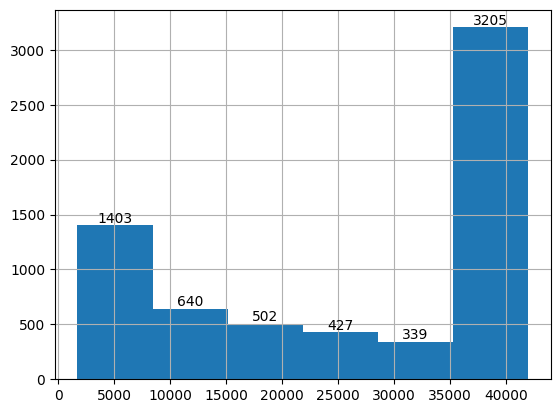

In [9]:
from sklearn.preprocessing import StandardScaler

columns_to_normalize = ['Depth', 'Total Activations', 'Total_Activations_Batch_Size', 'Total Parameters', 'Batch Size',
               'Conv2d Count','BatchNorm2d Count', 'Dropout Count', 'AdaptiveAvgPool2d Count',
               'Linear Count', 'Max GPU Memory (MiB)',
            #    'Input Size (MB)', 'Forward/Backward Pass Size (MB)','Params Size (MB)', 'Estimated Total Size (MB)'
               ]


# # Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler and transform the data
df_normalized = pd.DataFrame(scaler.fit_transform(df[columns_to_normalize]), columns=columns_to_normalize)
print(df_normalized.columns, len(df_normalized), df_normalized.head())

print(df[["Activation Function"]])
print(df.columns)
df['Max GPU Memory (MiB)'].hist(bins=6)

# Adding labels to the bins
for ax in plt.gcf().axes:
    for patch in ax.patches:
        # Get the coordinates and height of each bar (bin)
        height = patch.get_height()
        width = patch.get_width()
        # Calculate the position where the text will be displayed
        bin_center = patch.get_x() + width / 2
        # Display the height (number of items in each bin)
        ax.text(bin_center, height, int(height), ha='center', va='bottom')

plt.show()

# Hard Labeling

In [10]:
import pandas as pd

# Sample DataFrame for demonstration
# df = pd.DataFrame({
#     'Max GPU Memory (MiB)': [1000, 5000, 15000, 22000, 30000, 45000, 52000, 60000] * 10
# })

# Define your bins and labels
# bins = [0, 10000, 20000, 30000, 40000, 45000]
bins = [0, 8000, 16000, 24000, 32000, 40000, 50000]
labels = [i for i in range(0, len(bins) - 1)]

# Create the 'memory_usage_label' column
df['memory_usage_label'] = pd.cut(df['Max GPU Memory (MiB)'], bins=bins, labels=labels, right=False)

# Count instances per class
class_counts = df['memory_usage_label'].value_counts()

# Determine the target count (minimum count)
target_count = class_counts.min()

# Create a balanced DataFrame
balanced_df = pd.DataFrame()

for label in labels:
    # Select samples for each label
    if class_counts[label] > target_count:
        # Downsample if there are more samples than the target count
        samples = df[df['memory_usage_label'] == label].sample(target_count, random_state=42)
    else:
        # Upsample if there are fewer samples than the target count
        samples = df[df['memory_usage_label'] == label].sample(target_count, replace=True, random_state=42)

    balanced_df = pd.concat([balanced_df, samples])

# Reset index of the balanced DataFrame
balanced_df.reset_index(drop=True, inplace=True)

# Display the balanced DataFrame and the counts of each class
print(balanced_df['memory_usage_label'].value_counts())
print(balanced_df)


memory_usage_label
0    451
1    451
2    451
3    451
4    451
5    451
Name: count, dtype: int64
      Depth Activation Function  Total Activations  \
0         9               PReLU           18410131   
1        87               PReLU           16588306   
2         5               PReLU            1510710   
3        18               PReLU           49784955   
4        67                GELU           31443955   
...     ...                 ...                ...   
2701     79           LeakyReLU          594946931   
2702     60                ReLU         1281488822   
2703     47                Mish          144960866   
2704     87            Softplus         1145048346   
2705     75                 ELU         1949808842   

      Total_Activations_Batch_Size  Total Parameters  Batch Size  \
0                        846866026             45060          46   
1                        564002404           2562416          34   
2                         60428400             9

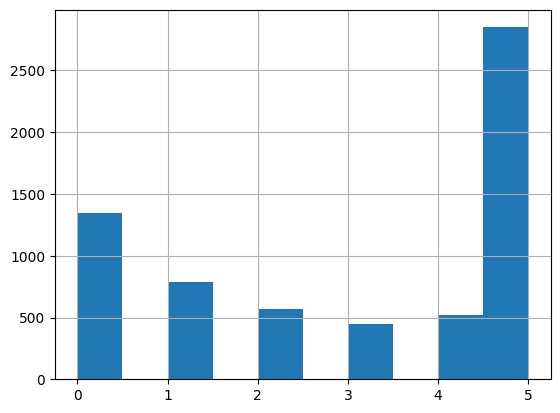

<Axes: >

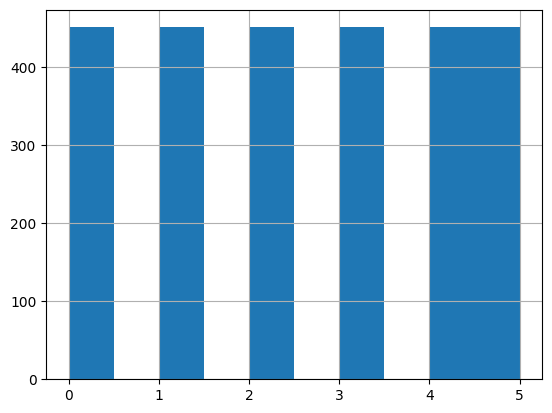

In [11]:
df['memory_usage_label'].hist()

plt.show()

balanced_df['memory_usage_label'].hist()

In [12]:
from sklearn.model_selection import train_test_split
x_train, x_temp, y_train, y_temp = train_test_split(
    df[['Depth','Total Activations', 'Total_Activations_Batch_Size', 'Total Parameters', 'Batch Size',
        'Conv2d Count', 'BatchNorm2d Count', 'Dropout Count', 'activation_encoding_sin',
        'activation_encoding_cos',
        # 'Input Size (MB)', 'Forward/Backward Pass Size (MB)','Params Size (MB)', 'Estimated Total Size (MB)',
        ]].values, df['memory_usage_label'].values, test_size=0.3, random_state=42)

x_test, x_val, y_test, y_val = train_test_split(
    x_temp, y_temp, test_size=0.66, random_state=42)

print('total data size: ', len(df))
print(f"train size {len(x_train)}, val size: {len(x_val)}, test size: {len(x_test)}")

total data size:  6516
train size 4561, val size: 1291, test size: 664


In [13]:
from torch.utils.data import Dataset, DataLoader

# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, inputs, targets):
        # Store the input and target data
        self.inputs = torch.tensor(inputs, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        # Returns the total number of samples
        return len(self.inputs)

    def __getitem__(self, idx):
        # Return a single sample (input, target pair)
        return self.inputs[idx], self.targets[idx]

train_dataloader = DataLoader(CustomDataset(x_train, y_train), 512, num_workers=2, shuffle=True)
val_dataloader = DataLoader(CustomDataset(x_val, y_val), 512, num_workers=2)
test_dataloader = DataLoader(CustomDataset(x_test, y_test),1, num_workers=1)
x, y = next(iter(train_dataloader))
print(f"input shape: {x.shape}, output shape: {y.shape}")

input shape: torch.Size([512, 10]), output shape: torch.Size([512])


In [14]:
class FC_base(nn.Module):
    def __init__(self, input_features, output_features, base_features):
        super(FC_base, self).__init__()

        # Define the network architecture
        self.fc1 = nn.Linear(input_features, base_features)
        self.bn1 = nn.BatchNorm1d(base_features)
        self.fc2 = nn.Linear(base_features, base_features)
        self.bn2 = nn.BatchNorm1d(base_features)
        self.fc3 = nn.Linear(base_features, base_features)
        self.bn3 = nn.BatchNorm1d(base_features)
        self.fc4 = nn.Linear(base_features, base_features)
        self.bn4 = nn.BatchNorm1d(base_features)
        self.fc5 = nn.Linear(base_features, base_features)
        self.bn5 = nn.BatchNorm1d(base_features)
        self.fc6 = nn.Linear(base_features, base_features)
        self.bn6 = nn.BatchNorm1d(base_features)

        self.final = nn.Linear(base_features, output_features)
        # self.dropout = nn.Dropout(p=0.0)
        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.relu(self.bn4(self.fc4(x)))
        x = self.relu(self.bn5(self.fc5(x)))
        x = self.relu(self.bn6(self.fc6(x)))
        x = self.final(x)
        return x

In [15]:
from pytorch_lightning import seed_everything

seed = 11  # Set your desired seed
seed_everything(seed, workers=True)
torch.use_deterministic_algorithms(False)


INFO:lightning_fabric.utilities.seed:Seed set to 11


In [16]:
class classification_gpu_usage(pl.LightningModule):
    def __init__(self, output_size):
        super(classification_gpu_usage, self).__init__()
        # Define your model
        self.model = FC_base(input_features=10, output_features=output_size, base_features=9)
        self.criterion = nn.CrossEntropyLoss()
        # self.criterion = nn.BCEWithLogitsLoss()
        self.output_size = output_size

        # Apply weight initialization
        self.apply(self._initialize_weights)

    def _initialize_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)  # Xavier uniform initialization
            if module.bias is not None:
                nn.init.zeros_(module.bias)  # Initialize bias to zeros


    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch[0], batch[1]
        y = y.long()
        # Apply label smoothing to the target labels
        # smoothed_labels = smooth_labels(y, self.output_size, self.smoothing)

        # assert (y >= 0).all() and (y < self.output_size).all(), "Labels are out of bounds."


        logits = self.forward(x)
        loss = self.criterion(logits, y)

        # Calculate accuracy
        acc = (logits.argmax(dim=1) == y).float().mean()

        # Log loss and accuracy
        self.log('train_loss', loss, on_epoch=True, on_step=False)
        self.log('train_acc', acc, on_epoch=True, on_step=False)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch[0], batch[1]
        y = y.long()

        # assert (y >= 0).all() and (y < self.output_size).all(), "Labels are out of bounds."

        logits = self.forward(x)
        loss = self.criterion(logits, y)
        # Calculate accuracy
        acc = (logits.argmax(dim=1) == y).float().mean()

        # Log loss and accuracy
        self.log('val_loss', loss, on_epoch=True, on_step=False, prog_bar=True)
        self.log('val_acc', acc, on_epoch=True, on_step=False, prog_bar=True)

        return loss

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=0.001)

        # Use a scheduler that doesn't require setting the learning rate explicitly
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss',
                'frequency': 1
            }
        }
        # return optimizer

In [17]:
from torchsummary import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)
print(len(labels))

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=30, verbose=True, mode='min')


classifier_model = classification_gpu_usage(output_size = len(labels)).to(device)

summary(classifier_model, input_size=(10,), device=device)

cuda
6
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 9]              99
       BatchNorm1d-2                    [-1, 9]              18
              ReLU-3                    [-1, 9]               0
            Linear-4                    [-1, 9]              90
       BatchNorm1d-5                    [-1, 9]              18
              ReLU-6                    [-1, 9]               0
            Linear-7                    [-1, 9]              90
       BatchNorm1d-8                    [-1, 9]              18
              ReLU-9                    [-1, 9]               0
           Linear-10                    [-1, 9]              90
      BatchNorm1d-11                    [-1, 9]              18
             ReLU-12                    [-1, 9]               0
           Linear-13                    [-1, 9]              90
      BatchNorm1d-14            

In [18]:
classifier_model.train()

classifier_model.train()
trainer = pl.Trainer(
    max_epochs=600,
    callbacks=[early_stopping],
)
# Train the model
trainer.fit(classifier_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | FC_base          | 717    | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
717       Trainable params
0         Non-trainable params
717       Total params
0.003     Total estimated model params size (MB)
16        Modules in train mode
0      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 1.798


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 1.780


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.772


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.750


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.085 >= min_delta = 0.0. New best score: 1.664


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.117 >= min_delta = 0.0. New best score: 1.548


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.202 >= min_delta = 0.0. New best score: 1.346


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.095 >= min_delta = 0.0. New best score: 1.251


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 1.208


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 1.167


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.057 >= min_delta = 0.0. New best score: 1.110


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.070 >= min_delta = 0.0. New best score: 1.040


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.054 >= min_delta = 0.0. New best score: 0.986


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 0.942


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 0.903


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 0.869


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.087 >= min_delta = 0.0. New best score: 0.782


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.754


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 0.704


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.680


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 0.646


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.624


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 0.584


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.569


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.563


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.563


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.562


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.556


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.551


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.549


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.548


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.546


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.545


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.545


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.538


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.537


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.535


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.535


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.535


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.534


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.534


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.534


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.531


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.529


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.526


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.523


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.523


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.521


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.519


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.519


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.518


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.514


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.513


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.513


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.512


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.512


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.511


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.510


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.509


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.507


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.504


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.502


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.501


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.499


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.498


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.495


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.494


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.492


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.489


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.486


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.483


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.482


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.481


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.480


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.480


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.480


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 30 records. Best score: 0.480. Signaling Trainer to stop.


In [19]:
# save pytorch lightening model
# trainer.save_checkpoint("cnn_mlp_8g.ckpt")

In [37]:
# 'Depth','Total Activations', 'Total_Activations_Batch_Size', 'Total Parameters', 'Batch Size',
#         'Conv2d Count', 'BatchNorm2d Count', 'Dropout Count', 'activation_encoding_sin',
#         'activation_encoding_cos'

classifier_model.eval()
pred_list, gt = list(), list()
with torch.no_grad():
    for test_data in test_dataloader:
        pred = classifier_model(test_data[0])
        if test_data[1].item() != torch.argmax(pred, 1).item():
            # print(test_data[0][0][1])
            print(f"prediction: {torch.softmax(pred, 1)}, ground truth: {test_data[1]}", (((test_data[0][0][1] * test_data[0][0][4] + test_data[0][0][3]) + (test_data[0][0][3] * test_data[0][0][4]))*4)/(1024**2) )
        gt.append(test_data[1].item())
        pred_list.append(torch.argmax(pred, 1).item())

prediction: tensor([[0.0321, 0.2762, 0.5119, 0.1063, 0.0319, 0.0416]]), ground truth: tensor([3.]) tensor(13186.3164)
prediction: tensor([[0.0256, 0.0226, 0.0378, 0.0894, 0.3857, 0.4389]]), ground truth: tensor([4.]) tensor(33869.3281)
prediction: tensor([[0.0257, 0.0222, 0.0385, 0.0917, 0.3926, 0.4294]]), ground truth: tensor([4.]) tensor(33210.3086)
prediction: tensor([[0.0350, 0.0283, 0.2004, 0.4798, 0.2005, 0.0560]]), ground truth: tensor([2.]) tensor(23774.0234)
prediction: tensor([[0.3595, 0.3923, 0.1227, 0.0243, 0.0427, 0.0586]]), ground truth: tensor([0.]) tensor(5040.5356)
prediction: tensor([[0.0299, 0.2286, 0.5231, 0.1443, 0.0346, 0.0394]]), ground truth: tensor([4.]) tensor(17758.3809)
prediction: tensor([[0.0286, 0.0135, 0.0650, 0.2967, 0.4795, 0.1167]]), ground truth: tensor([3.]) tensor(26133.9219)
prediction: tensor([[0.0290, 0.0171, 0.0217, 0.0182, 0.1706, 0.7433]]), ground truth: tensor([4.]) tensor(43442.1641)
prediction: tensor([[0.3786, 0.3692, 0.1215, 0.0254, 0.04

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
def below_diagonal_sum_rate(confusion_matrix):
    # Convert to a numpy array for easier manipulation if not already
    confusion_matrix = np.array(confusion_matrix)

    # Sum the elements below the main diagonal (excluding the diagonal itself)
    below_diag_sum = np.sum(np.tril(confusion_matrix, k=-1))

    # Get the total number of data points
    total_data_points = np.sum(confusion_matrix)

    # Calculate the rate by dividing below-diagonal sum by total data points
    rate = below_diag_sum / total_data_points

    return rate

def calculate_metrics(gt, preds):
    # Calculate the various metrics
    accuracy = accuracy_score(gt, preds)
    precision = precision_score(gt, preds, average='weighted')  # Use 'weighted' to handle class imbalance
    recall = recall_score(gt, preds, average='weighted')
    f1 = f1_score(gt, preds, average='weighted')
    cm = confusion_matrix(gt, preds)

    # Print the results
    print("Accuracy: {:.4f}".format(accuracy))
    print("Precision: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    print("F1-Score: {:.4f}".format(f1))
    print("Below Diagonal Sum Rate: {:.4f}".format(below_diagonal_sum_rate(cm)))
    print("\nConfusion Matrix:")
    print(cm)

    # Full classification report
    print("\nClassification Report:")
    print(classification_report(gt, preds))

calculate_metrics(gt, pred_list)


Accuracy: 0.8373
Precision: 0.8322
Recall: 0.8373
F1-Score: 0.8327
Below Diagonal Sum Rate: 0.0708

Confusion Matrix:
[[135   7   0   0   0   0]
 [ 11  67  12   0   0   0]
 [  0  10  25   9   3   0]
 [  0   1  15  21  15   1]
 [  0   0   1   5  32  14]
 [  0   0   0   0   4 276]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.95      0.94       142
         1.0       0.79      0.74      0.77        90
         2.0       0.47      0.53      0.50        47
         3.0       0.60      0.40      0.48        53
         4.0       0.59      0.62      0.60        52
         5.0       0.95      0.99      0.97       280

    accuracy                           0.84       664
   macro avg       0.72      0.70      0.71       664
weighted avg       0.83      0.84      0.83       664



# Data Visualizations (PCA and TSNE)

In [22]:
from sklearn.manifold import TSNE

print(df.columns)

# Initialize the t-SNE model
tsne = TSNE(n_components=2, random_state=43)

# Fit and transform the features

# tsne_results = tsne.fit_transform(df[['all_activations', 'all_parameters', 'batch_size','total_activation_mul_batch_size', 'conv2d_layers','batch_norm2d_layer', 'dropout_layers']])
# tsne_results = tsne.fit_transform(df[['all_activations', 'all_parameters', 'batch_size','total_activation_mul_batch_size', 'conv2d_layers','batch_norm2d_layer']])

tsne_results = tsne.fit_transform(df[['Depth', 'Total Activations', 'Total Parameters', 'Batch Size',
                        'Conv2d Count', 'BatchNorm2d Count', 'Dropout Count', 'activation_encoding_sin','activation_encoding_cos',
                        # 'Input Size (MB)', 'Forward/Backward Pass Size (MB)','Params Size (MB)', 'Estimated Total Size (MB)'
                        ]])

Index(['Depth', 'Activation Function', 'Total Activations',
       'Total_Activations_Batch_Size', 'Total Parameters', 'Batch Size',
       'Conv2d Count', 'BatchNorm2d Count', 'Dropout Count',
       'AdaptiveAvgPool2d Count', 'Linear Count', 'Max GPU Memory (MiB)',
       'architecture', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)',
       'Params Size (MB)', 'Estimated Total Size (MB)',
       'activation_encoding_sin', 'activation_encoding_cos',
       'memory_usage_label'],
      dtype='object')


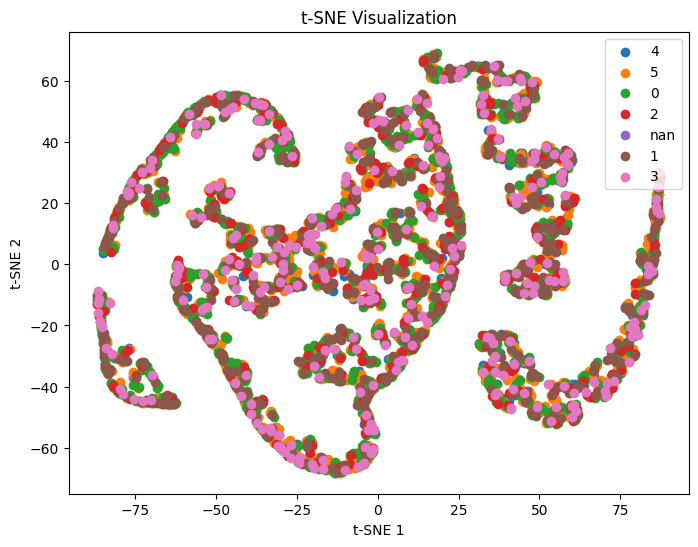

In [23]:
import matplotlib.pyplot as plt

# Create a new DataFrame for the t-SNE results
tsne_df = pd.DataFrame(tsne_results, columns=['tsne1', 'tsne2'])
tsne_df['label'] = df['memory_usage_label']

# Plot the results
plt.figure(figsize=(8, 6))
for label in tsne_df['label'].unique():
    subset = tsne_df[tsne_df['label'] == label]
    plt.scatter(subset['tsne1'], subset['tsne2'], label=label)

plt.title('t-SNE Visualization')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
plt.show()


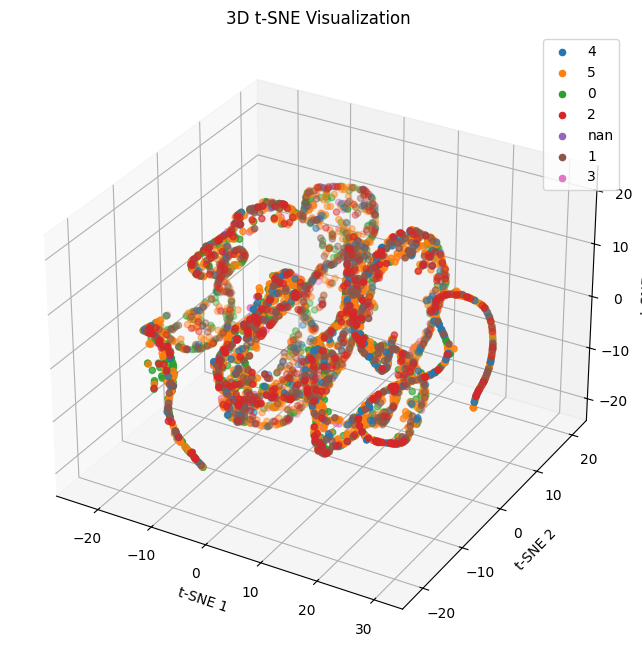

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

# Initialize the t-SNE model with 3 components
tsne = TSNE(n_components=3, random_state=43)


# Fit and transform the features

tsne_results = tsne.fit_transform(df[['Total Activations', 'Total Parameters', 'Batch Size', 'Total_Activations_Batch_Size',
                        'Conv2d Count', 'BatchNorm2d Count', 'Dropout Count', 'activation_encoding_sin',
                        'activation_encoding_cos', 'Input Size (MB)', 'Forward/Backward Pass Size (MB)',
                        'Params Size (MB)', 'Estimated Total Size (MB)']])

# Create a new DataFrame for the t-SNE results (3 components)
tsne_df = pd.DataFrame(tsne_results, columns=['tsne1', 'tsne2', 'tsne3'])
tsne_df['label'] = df['memory_usage_label']

# Plot the results in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for label in tsne_df['label'].unique():
    subset = tsne_df[tsne_df['label'] == label]
    ax.scatter(subset['tsne1'], subset['tsne2'], subset['tsne3'], label=label)

# Set plot title and labels
ax.set_title('3D t-SNE Visualization')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_zlabel('t-SNE 3')

# Add legend
plt.legend()

# Show the plot
plt.show()

# PCA

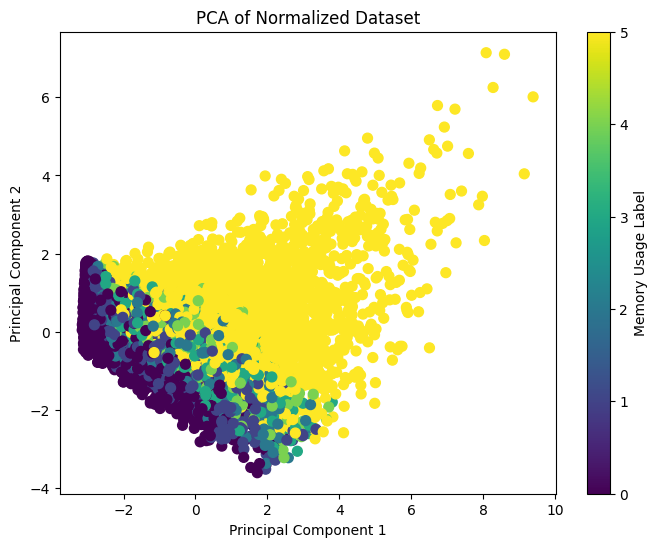

PCA Components:
[[ 0.46365149  0.40345708  0.36846371  0.37210306  0.02908962  0.41672544
   0.29452824  0.29450467 -0.00169075 -0.00586827]
 [-0.32494007  0.32739084  0.52489624  0.14815063  0.51673677 -0.22864424
  -0.26667894 -0.24323549  0.15690374 -0.1247778 ]]
Explained variance ratio:
[0.3727792  0.13392403]


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler  # Import for normalization

X = df[['Depth', 'Total Activations', 'Total_Activations_Batch_Size', 'Total Parameters', 'Batch Size',
        'Conv2d Count', 'BatchNorm2d Count', 'Dropout Count', 'activation_encoding_sin', 'activation_encoding_cos',
        # 'Input Size (MB)', 'Forward/Backward Pass Size (MB)', 'Params Size (MB)', 'Estimated Total Size (MB)'
        ]]
y = df['memory_usage_label']  # Output label for coloring

# Normalize the data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Apply PCA to reduce the dataset to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalized)

# Plotting the PCA-reduced data
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', s=50)
plt.colorbar(label='Memory Usage Label')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Normalized Dataset')

# Show the plot
plt.show()

components = pca.components_

# Get the explained variance ratio for each component (optional, to know how much variance each component explains)
explained_variance = pca.explained_variance_ratio_

# Show the components (each row corresponds to a principal component, each column corresponds to the original feature)
print("PCA Components:")
print(components)

# Show the explained variance ratio for each component
print("Explained variance ratio:")
print(explained_variance)

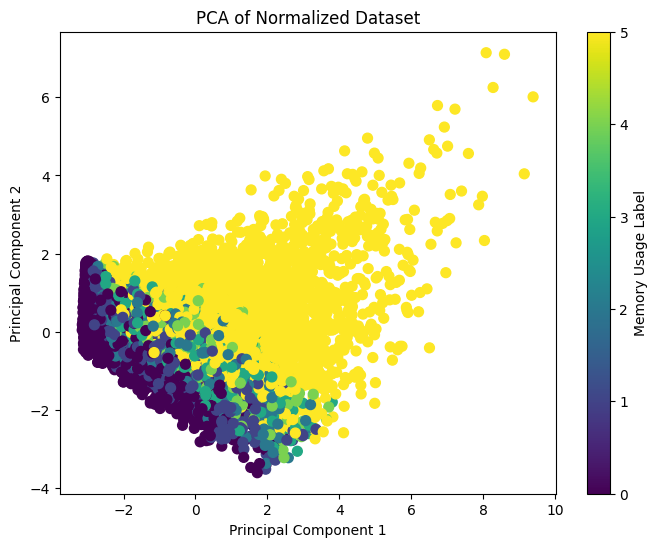

PCA Components:
[[ 0.46365149  0.40345708  0.36846371  0.37210306  0.02908962  0.41672544
   0.29452824  0.29450467 -0.00169075 -0.00586827]
 [-0.32494007  0.32739084  0.52489624  0.14815063  0.51673677 -0.22864424
  -0.26667894 -0.24323549  0.15690374 -0.1247778 ]]
Explained variance ratio:
[0.3727792  0.13392403]


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler  # Import for normalization

# Assuming you have a pandas DataFrame 'df'
# df = pd.read_csv('your_dataset.csv')  # Uncomment if loading from a file


# Example DataFrame columns: 'layers', 'batch_size', 'all_parameters', 'all_activations', 'memory_usage_label'
# X = df[['all_activations', 'all_parameters', 'batch_size', 'conv2d_layers','batch_norm2d_layer', 'dropout_layers']]  # Input features
X = df[['Depth', 'Total Activations', 'Total_Activations_Batch_Size', 'Total Parameters', 'Batch Size',
        'Conv2d Count', 'BatchNorm2d Count', 'Dropout Count', 'activation_encoding_sin', 'activation_encoding_cos',
        # 'Input Size (MB)', 'Forward/Backward Pass Size (MB)', 'Params Size (MB)', 'Estimated Total Size (MB)'
        ]]
y = df['memory_usage_label']  # Output label for coloring

# Normalize the data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Apply PCA to reduce the dataset to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalized)

# Plotting the PCA-reduced data
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', s=50)
plt.colorbar(label='Memory Usage Label')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Normalized Dataset')

# Show the plot
plt.show()

components = pca.components_

# Get the explained variance ratio for each component (optional, to know how much variance each component explains)
explained_variance = pca.explained_variance_ratio_

# Show the components (each row corresponds to a principal component, each column corresponds to the original feature)
print("PCA Components:")
print(components)

# Show the explained variance ratio for each component
print("Explained variance ratio:")
print(explained_variance)

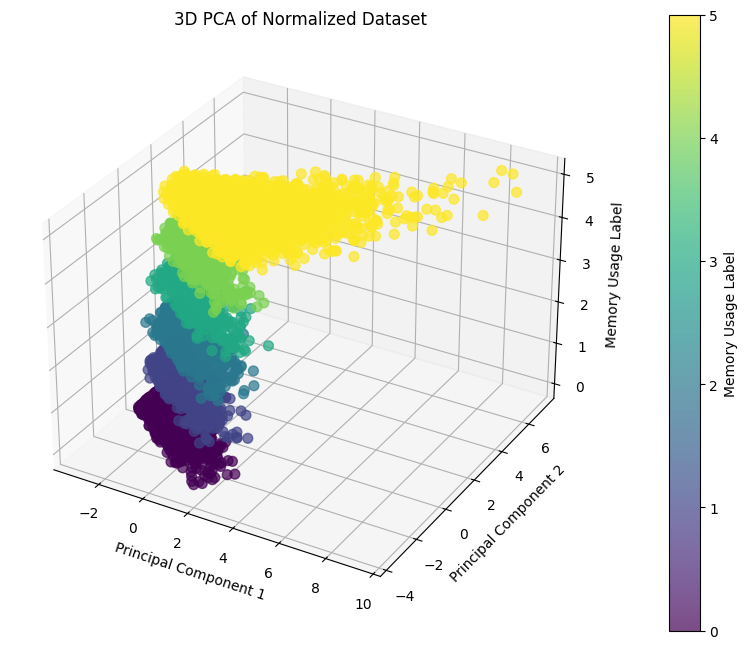

PCA Components:
[[ 0.46365149  0.40345708  0.36846371  0.37210306  0.02908962  0.41672544
   0.29452824  0.29450467 -0.00169075 -0.00586827]
 [-0.32494007  0.32739084  0.52489624  0.14815063  0.51673677 -0.22864424
  -0.26667894 -0.24323549  0.15690374 -0.1247778 ]]
Explained Variance Ratio:
[0.3727792  0.13392403]


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import for 3D plotting
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming you have a pandas DataFrame 'df'
# df = pd.read_csv('your_dataset.csv')  # Uncomment if loading from a file

X = df[['Depth', 'Total Activations', 'Total_Activations_Batch_Size', 'Total Parameters', 'Batch Size',
        'Conv2d Count', 'BatchNorm2d Count', 'Dropout Count', 'activation_encoding_sin', 'activation_encoding_cos',
        # 'Input Size (MB)', 'Forward/Backward Pass Size (MB)', 'Params Size (MB)', 'Estimated Total Size (MB)'
        ]]
y = df['memory_usage_label']  # Output label for coloring

# Normalize the data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Apply PCA to reduce the dataset to 2 dimensions
pca = PCA(n_components=2)  # Change to 3 components for 3D plotting
X_pca = pca.fit_transform(X_normalized)

# Plotting the PCA-reduced data in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], y, c=y, cmap='viridis', s=50, alpha=0.7)

# Labels and title
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Memory Usage Label')
ax.set_title('3D PCA of Normalized Dataset')

# Colorbar
cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Memory Usage Label')

# Show the plot
plt.show()

# Retrieve and display PCA components and explained variance ratio
components = pca.components_
explained_variance = pca.explained_variance_ratio_

print("PCA Components:")
print(components)

print("Explained Variance Ratio:")
print(explained_variance)


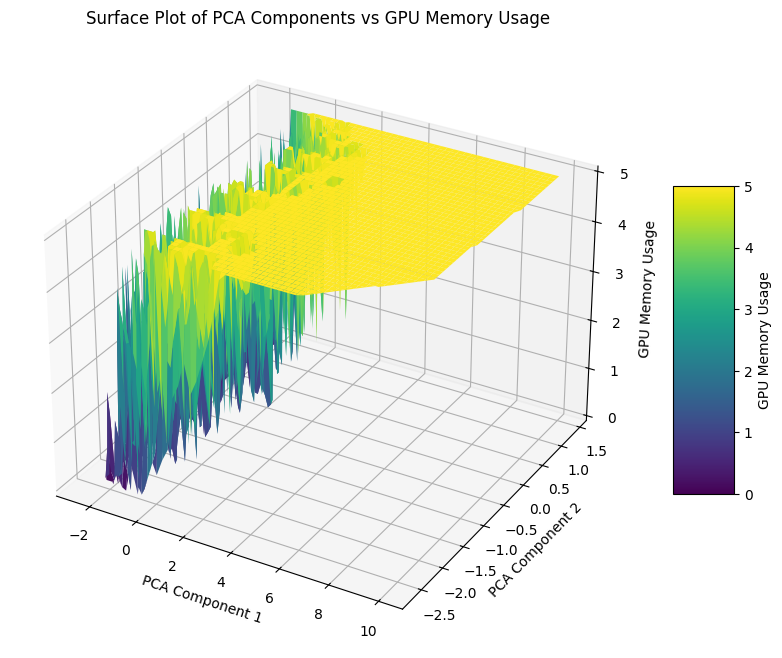

PCA Components:
[[ 4.98231998e-01  4.43441305e-01  5.70378301e-02  4.68329158e-01
   4.17762171e-01  2.81524796e-01  2.80587599e-01  1.70281868e-04
  -5.31954332e-03]
 [-9.14949091e-03  8.74998392e-04  1.13490616e-01  3.14334591e-02
  -1.92147689e-02 -2.10320941e-02 -2.46736117e-02  7.02518512e-01
  -7.00781518e-01]]
Explained variance ratio:
[0.33422943 0.14415431]


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import griddata

# Example DataFrame columns: 'layers', 'batch_size', 'all_parameters', 'all_activations', 'memory_usage_label'
# Assuming you have a pandas DataFrame 'df'
# df = pd.read_csv('your_dataset.csv')  # Uncomment if loading from a file

# Prepare data
X = df[['Total Activations', 'Total Parameters', 'Batch Size', 'Total_Activations_Batch_Size',
        'Conv2d Count', 'BatchNorm2d Count', 'Dropout Count', 'activation_encoding_sin','activation_encoding_cos',
        # 'Input Size (MB)', 'Forward/Backward Pass Size (MB)', 'Params Size (MB)', 'Estimated Total Size (MB)'
        ]]
y = df['memory_usage_label']  # Actual GPU memory usage

# Normalize the data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Apply PCA to reduce the dataset to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalized)

# Extract PCA components
pca1 = X_pca[:, 0]
pca2 = X_pca[:, 1]

# Create grid for surface plot
pca1_grid, pca2_grid = np.meshgrid(np.linspace(pca1.min(), pca1.max(), 100),
                                   np.linspace(pca2.min(), pca2.max(), 100))

# Interpolate to fit the GPU memory usage on the grid
memory_usage_grid = griddata((pca1, pca2), y, (pca1_grid, pca2_grid), method='linear')

# Plotting the PCA-reduced data with GPU memory usage as a surface
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot surface
surf = ax.plot_surface(pca1_grid, pca2_grid, memory_usage_grid, cmap='viridis', edgecolor='none')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('GPU Memory Usage')
ax.set_title('Surface Plot of PCA Components vs GPU Memory Usage')

# Add color bar
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('GPU Memory Usage')

plt.show()

# Output PCA components and explained variance ratio
components = pca.components_
explained_variance = pca.explained_variance_ratio_

print("PCA Components:")
print(components)

print("Explained variance ratio:")
print(explained_variance)